<a href="https://colab.research.google.com/github/PaSeitz/BA-Fahrzeugerkennung/blob/main/Fahrzeugerkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fahrzeug**erkennung

# **Bounding Box Detection** Modul

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')
!git clone --depth 1 https://github.com/tensorflow/models

Object Detection **API** installieren.

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

**GPU** verwenden. Sollte ein Fehler auftreten, dann muss die **GPU** manuell als Hardwarebeschleuniger ausgewählt werden. 
* *Laufzeit -> Laufzeittyp ändern -> **GPU** -> Speichern*.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

**EfficientNet**-D5 von TensorFlow Hub herunterladen. 

In [5]:
from object_detection.utils import label_map_util
model = hub.load('https://tfhub.dev/tensorflow/efficientdet/d5/1')
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Auswahlmöglichkeit verschiedener **Kategorien**.

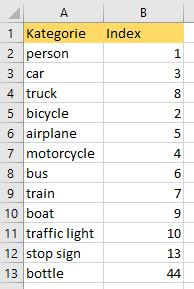


Für die gesamte Kategorieübersicht:

* *models / research / object_detection / data / mscoco_label_map.pbtxt*

In [6]:
detection_class_indices = [3,8]

In [7]:
#@title **Funktionen** initialisieren. { display-mode: "form" }
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
import shutil

def create_overlay(result,image_np,threshold=.5):
  image_np_with_detections = image_np.copy()
  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]
  viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    result['detection_boxes'][0],
    (result['detection_classes'][0]).astype(int),
    result['detection_scores'][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=threshold,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores)
  return Image.fromarray(image_np_with_detections[0])

def detection(image_path,threshold=.55):
  image_np = np.expand_dims(np.asarray(load_image(image_path)),axis=0)
  results = model(image_np)
  result = {key:value.numpy() for key,value in results.items()}
  return [result,image_np]

def find_focused_car(image_path,threshold=.3,padding=16):
  max_area = 0
  focused_car_image = None
  [result,image_np] =  detection(image_path,threshold)
  detection_scores = result.get('detection_scores')[0]
  detection_boxes =  result.get('detection_boxes')[0]
  detection_classes = result.get('detection_classes')[0]
  image = Image.fromarray(image_np[0])
  for i in range(len(detection_scores)):
    if detection_classes[i] not in detection_class_indices:
      continue
    if detection_scores[i]>threshold:
      x1 = image.width*detection_boxes[i][1]-padding
      y1 = image.height*detection_boxes[i][0]-padding
      x2 = image.width*detection_boxes[i][3]+padding
      y2 = image.height*detection_boxes[i][2]+padding
      if x1<0:
        x1 = 0
      if y1<0:
        y1 = 0
      if x2>image.width:
        x2 = image.width
      if y2>image.height:
        y2 = image.height
      area = (x2-x1)*(y2-y1)
      if area>max_area:
        max_area = area
        focused_car_image = image.crop((x1,y1,x2,y2))
  return focused_car_image

def crop_images(image_path,output_folder_path='temp',threshold=.5,padding=16):
  if os.path.exists(output_folder_path):
    shutil.rmtree(output_folder_path)
  os.mkdir(output_folder_path)
  [result,image_np] =  detection(image_path)
  detection_scores = result.get('detection_scores')[0]
  detection_boxes =  result.get('detection_boxes')[0]
  detection_classes = result.get('detection_classes')[0]
  image = Image.fromarray(image_np[0])
  for i in range(len(detection_scores)):
    if detection_classes[i] not in detection_class_indices:
      continue
    if detection_scores[i]>threshold:
      x1 = image.width*detection_boxes[i][1]-padding
      y1 = image.height*detection_boxes[i][0]-padding
      x2 = image.width*detection_boxes[i][3]+padding
      y2 = image.height*detection_boxes[i][2]+padding
      if x1<0:
        x1 = 0
      if y1<0:
        y1 = 0
      if x2>image.width:
        x2 = image.width
      if y2>image.height:
        y2 = image.height
      im_crop = image.crop((x1,y1,x2,y2))
      im_crop.save(output_folder_path + '/' + str(i) +'.jpg', quality=95)

# **Embedding** Modul

**EfficientNet**-D5 mit dem imagenet Datensatz als *Embedding* Modell verwenden.  

In [ ]:
from tensorflow.keras.applications import EfficientNetB5 as EN5
from keras import Model
modelEfficientNet = EN5(weights='imagenet') 
embeddingModel = Model(inputs = modelEfficientNet.input, outputs = modelEfficientNet.layers[-3].output)

In [9]:
#@title **Funktionen** für Datenerweiterung initialisieren. { display-mode: "form" }
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import random

def load_image(path,resize=True,width=456,height=456):
  image = Image.open(path).convert('RGB')
  if resize:
    return image.resize((width,height), Image.ANTIALIAS)
  return image

def flip(image):
  return ImageOps.flip(image.copy())

def mirror(image):
  return ImageOps.mirror(image.copy())

def blur(image,size=2):
  return image.copy().filter(ImageFilter.GaussianBlur(size))

def rotate(image,angle):
  return image.copy().rotate(angle)

def enhance(image,factor=0.5):
  enhancer = ImageEnhance.Brightness(image.copy())
  return enhancer.enhance(factor)

def add_noise(image,propability=0.05):
  image_clone = image.copy()
  for x in range(image_clone.width):
    for y in range(image_clone.height):
      if random.random() < propability:
        image_clone.putpixel(xy=(x,y),value=0)
  return image_clone

**Methoden** für die Erweiterung des Datensatzes auswählen.

In [10]:
def data_augmentation_batch(image):
  batch_names = []
  batch = []
  batch.append(np.asarray(image))
  batch_names.append('Base')
  batch.append(np.asarray(mirror(image)))
  batch_names.append('Mirror')
  batch.append(np.asarray(add_noise(image)))
  batch_names.append('Noise')
  batch.append(np.asarray(rotate(image,-5)))
  batch_names.append('Rotate (-5°)')
  batch.append(np.asarray(rotate(image,5)))
  batch_names.append('Rotate (+5°)')
  batch.append(np.asarray(flip(image)))
  batch_names.append('Flip')
  batch.append(np.asarray(blur(image)))
  batch_names.append('Blur')
  batch.append(np.asarray(enhance(image,0.8)))
  batch_names.append('Enhance (0.8)')
  batch.append(np.asarray(enhance(image,1.2)))
  batch_names.append('Enhance (1.2)')
  return [batch,batch_names]

In [24]:
#@title **Funktionen** für den *Embedding Process* initialisieren. { display-mode: "form" }
import csv
import os
import numpy as np
from IPython.display import HTML, display, clear_output
import time

def create_columns(size):
  columns = []
  columns.append('category')
  for i in range(size):
    columns.append('n' + str(i))
  return columns

def create_csv_file(output_file_name,size=2048):
  with open(output_file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(create_columns(size))

def write_to_csv(output_file_name,data):
  with open(output_file_name, 'a') as file:
    writer = csv.writer(file)
    writer.writerow(data)

def read_csv(file_name,categories=None,remove_header_row=True):
  with open(file_name, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    X = []
    Y = []
    for row in reader:
      if remove_header_row:
        remove_header_row = False
        continue
      Y.append(row[0])
      X.append(row[1:])
  return [X,Y]

def convert_labels_to_number(Y):
  label_index = 0
  categories = set(Y)
  for category in categories:
    for i in range(len(Y)):
      if Y[i] == category:
        Y[i] = label_index
    label_index = label_index + 1
  return categories

def calculate_estimate_time_for_single_image(image_path,auto_crop):
  start_time = time.time()
  if auto_crop:
    image = find_focused_car(image_path,.25,0)
  else:
    image = load_image(image_path)
  [batch,batch_names] = data_augmentation_batch(image)
  for i in range(len(batch)):
    embeddingModel.predict(np.expand_dims(batch[i],axis=0))
  return time.time()-start_time

def count_number_of_images(dataset_path):
  image_count = 0
  categories = next(os.walk(dataset_path))[1]
  for category in categories:
    category_path = os.path.join(dataset_path,category)
    image_count += len(os.listdir(category_path))
  return image_count

def generate_embeddings(database_file_path,dataset_path,auto_crop=False):
  if not os.path.exists(database_file_path):
    create_csv_file(database_file_path)
  number_of_images = count_number_of_images(dataset_path)
  base_time = -1
  calculate_base_time = True
  categories = next(os.walk(dataset_path))[1]
  for category in categories:
    category_path = os.path.join(dataset_path,category)
    files_in_category = os.listdir(category_path)
    for filename in files_in_category:
      clear_output()
      image_path = os.path.join(category_path,filename)
      if calculate_base_time:
        calculate_estimate_time_for_single_image(image_path,auto_crop)
        base_time = calculate_estimate_time_for_single_image(image_path,auto_crop)
        calculate_base_time = False
      print('Number of images remaining: ' + str(number_of_images))
      print('Estimated time remaining : ' + str(round(base_time*number_of_images/60)) + ' minutes')
      number_of_images -= 1
      image = None
      if auto_crop:
        image = find_focused_car(image_path,.25,0)
      else:
        image = load_image(image_path)
      if image is None:
        continue
      # -------------------- Datenerweiterung ---------------------------
      [batch,batch_names] = data_augmentation_batch(image)
      # -------------------- Datenerweiterung ---------------------------
      for i in range(len(batch)):
        write_to_csv(database_file_path,[category] + list(embeddingModel.predict(np.expand_dims(batch[i],axis=0))[0]))

# Bestehenden **Daten**satz verwenden. 
**ZIP**-Datei hochladen ...


In [ ]:
from google.colab import files
import zipfile
uploaded = files.upload()
for fn in uploaded.keys():
  zip_file_name = fn
dataset_folder = 'dataset'
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

... oder bestehende **CSV** Datenbank verwenden.

In [ ]:
csv_databaset_path = 'database.csv'

# **Daten**satz mit Bing Bildersuche erstellen.

In [ ]:
pip install bing-image-downloader

In [13]:
number_of_images_per_class = 100
car_models = [
   'Mercedes benz EQC',
   'Renault ZOE LIFE R110 Z.E'           
]

In [ ]:
#@title **Bilder** suchen. { display-mode: "form" }
from bing_image_downloader import downloader
dataset_folder = 'dataset'
for car_model in car_models:
  downloader.download(car_model, limit=number_of_images_per_class,  output_dir=os.path.join(dataset_folder,'Datensatz'), adult_filter_off=True, force_replace=False, timeout=60)

# **Embeddings** erstellen.

In [ ]:
# auto_crop auf True setzen falls Bing Bildersuche verwendet oder der Datensatz noch nicht zugeschnitten wurde.
ds_folder = 'dataset'
generate_embeddings('database.csv',ds_folder,auto_crop=True)

Estimated time : 20 minutes
Base done!
Mirror done!
Noise done!
Rotate (-5°) done!
Rotate (+5°) done!
Flip done!
Blur done!
Enhance (0.8) done!
Enhance (1.2) done!


# **Logistic** Regression Modul.

In [26]:
from sklearn.linear_model import LogisticRegression

def create_logistic_regressor(X,Y,solver='liblinear'):
  logistic_regressor = LogisticRegression(solver=solver, random_state=0)
  logistic_regressor.fit(X, Y)
  return logistic_regressor

def logistic_regressor_predicition(image_path,categories):
  embedding = embeddingModel.predict(np.expand_dims(np.asarray(load_image(image_path)),axis=0))
  return categories[logistic_regressor.predict(embedding)[0]]

In [27]:
[X,Y] = read_csv('database.csv')
categories = list(convert_labels_to_number(Y))
logistic_regressor = create_logistic_regressor(X,Y)

# **Telegram** Bot.

In [28]:
# Insert your token here
TOKEN = ''

In [ ]:
#@title **Bot** initialisieren. { display-mode: "form" }
!pip install pyTelegramBotAPI
import telebot
bot = telebot.TeleBot(TOKEN)

@bot.message_handler(func=lambda message: True, content_types=['photo'])
def default_command(message):
    image = bot.get_file(message.photo[-1].file_id)
    downloaded_file = bot.download_file(image.file_path)
    with open("image.jpg", 'wb') as new_file:
        new_file.write(downloaded_file)
    crop_images('image.jpg','temp',0.3,0)
    for filename in os.listdir('temp'):
      image_path = os.path.join('temp',filename)
      prediction = logistic_regressor_predicition(image_path,categories)
      bot.send_photo(message.chat.id, photo=open(image_path, 'rb'))
      bot.reply_to(message, prediction)

In [30]:
#@title **Bot** starten. { display-mode: "form" }
bot.polling()